## Modules

In [1]:
from sklearn import metrics
import scikitplot as skplt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

In [2]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn import linear_model, decomposition, datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.decomposition import PCA
import scikitplot as skplt

In [3]:
def clean_my_file(file_name):
    
    # read csv
    exp = pd.read_csv(file_name)
    # list of freqs
    
    list_of_freqs = exp.columns[12::].to_list()
    
    # index of first real freq
    index = list_of_freqs.index('-12')
    
    # normalize
    norm_factor = exp[ list_of_freqs[0:index-1] ].iloc[:,-1]
    
    raw_data = exp[ list_of_freqs[index::] ]
    
    # preallocate with zeros
    Zspectra = np.zeros(raw_data.shape)
    
    
    for i in range(raw_data.shape[0]):
        Zspectra[i,:] = raw_data.iloc[i,:] / norm_factor[i]
        
        
   
    #out[exp.columns[0:11].to_list()] = exp.columns[0:11].copy()
    
    out = exp[ exp.columns[0:11] ].copy()
    
    out['FILE']  = file_name.split('/NewMegaBox1to8_MLData_20200901/')[1]
    
    Z = pd.DataFrame(Zspectra, columns= list_of_freqs[index::])
    
    out[Z.columns] = Z.copy()
    
    return out
    


### Load data

In [4]:
%%time

import os
from glob import glob
PATH = "./NewMegaBox1to8_MLData_20200901"
EXT = "*.csv"
all_csv_files = [file
                 for path, subdir, files in os.walk(PATH)
                 for file in glob(os.path.join(path, EXT))]

data = pd.DataFrame()

for file in all_csv_files:
    exp = clean_my_file(file)
    data = pd.concat( (data,  exp), sort=False )
    

CPU times: user 1min 32s, sys: 14 s, total: 1min 46s
Wall time: 1min 47s


In [5]:
data.tail()

,pH,Conc(mM),ApproT1(sec),ExpT1(ms),ExpT2(ms),ExpB1(percent),ExpB0(ppm),ExpB0(Hz),Temp,SatPower(uT),...,7,7.2,7.4,7.6,7.8,8,9,10,11,12
21,6.38,9.9631,3.4,4112.5,601.83,101.610,0.22259,66.852,37,4.0,...,0.957295,0.957801,0.955397,0.963685,0.965772,0.971340,0.970454,0.969379,0.977224,0.973871
22,6.58,9.9631,3.4,3918.7,575.72,109.390,0.33517,100.660,37,4.0,...,0.940677,0.947761,0.947329,0.948518,0.962200,0.957766,0.959604,0.972637,0.972475,0.975827
23,6.70,9.9473,3.4,3911.1,593.31,106.630,0.40331,121.130,37,4.0,...,0.938586,0.947827,0.960817,0.957015,0.945187,0.958494,0.969953,0.978560,0.972963,0.975022
24,6.88,9.9206,3.4,4043.4,632.75,99.980,0.35798,107.510,37,4.0,...,0.949383,0.938830,0.944454,0.961153,0.959413,0.963356,0.961674,0.969676,0.977967,0.983243
25,7.02,9.9512,3.4,3882.0,638.70,81.981,0.31547,94.747,37,4.0,...,0.931650,0.925942,0.942780,0.943350,0.939141,0.951627,0.953696,0.957620,0.955908,0.962329


## Experimental conditions

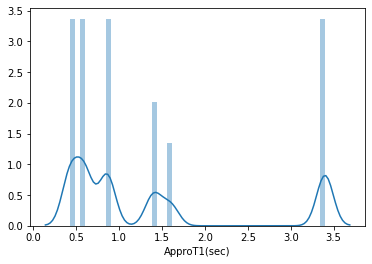

In [11]:
sns.distplot(data['ApproT1(sec)'])

In [9]:
metadata = ['pH', 'Conc(mM)', 'ApproT1(sec)', 'ExpT1(ms)', 'ExpT2(ms)',
       'ExpB1(percent)', 'ExpB0(ppm)', 'ExpB0(Hz)', 'Temp',
       'SatPower(uT)', 'SatTime(ms)','FILE']


for C in metadata:
    print(C)
    print(data[C].nunique())
    #sns.distplot(data[C])
    print('---'*20)

pH
54
------------------------------------------------------------
Conc(mM)
153
------------------------------------------------------------
ApproT1(sec)
6
------------------------------------------------------------
ExpT1(ms)
996
------------------------------------------------------------
ExpT2(ms)
987
------------------------------------------------------------
ExpB1(percent)
889
------------------------------------------------------------
ExpB0(ppm)
996
------------------------------------------------------------
ExpB0(Hz)
996
------------------------------------------------------------
Temp
5
------------------------------------------------------------
SatPower(uT)
6
------------------------------------------------------------
SatTime(ms)
6
------------------------------------------------------------
FILE
1440
------------------------------------------------------------


# Data

In [14]:
%%time

X = data.drop(metadata, axis = 1)
print(len(metadata))
print(X.shape)

pH = data['pH'].copy()

12
(36000, 81)
CPU times: user 6.33 ms, sys: 98 µs, total: 6.43 ms
Wall time: 6.36 ms


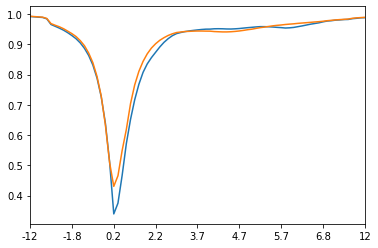

In [15]:
X[data.pH == 6.22].mean(axis = 0).plot()
X[data.pH == 7.30].mean(axis = 0).plot()

In [18]:
pH

0     6.24
1     6.38
2     6.58
3     6.69
4     6.84
      ... 
21    6.38
22    6.58
23    6.70
24    6.88
25    7.02
Name: pH, Length: 36000, dtype: float64

### PCA -- > Logistic Regression

In [103]:
### define function to train model based on cuttoff for pH

def train_logistic_PCA_pipeline(Spectra, pH_observed, min_n=2, max_n= 10, pH_cut_off = 7.0, n_cs=20, ignore_cut = False):
    
    if ignore_cut == False:
        # cut off > pH
        y = 1*(pH_observed > pH_cut_off)
    elif ignore_cut == True:
        
        y = pH_class.copy()
        
    # X data
    X = Spectra.copy()
        
    # Logistic
    logistic = linear_model.LogisticRegression(solver='liblinear',
                                               penalty='l1',max_iter=1000,random_state=42, n_jobs=2
                                               ,class_weight='balanced')
    # Scaler
    scale = StandardScaler()
    
    #PCA
    pca = PCA(random_state=42)
    
    # pipeline
    pipe = Pipeline(steps=[('scaler', scale ), ('pca', pca), ('logistic', logistic)])
    
    # Training parameters
    num_pca_components = np.arange(min_n,max_n,1)
    Cs = np.logspace(-3, 2, n_cs)
    
    param_grid ={
    'pca__n_components': num_pca_components,
    'logistic__C': Cs,
    'logistic__fit_intercept':[True,False]
    }
    
    
    estimator = GridSearchCV(pipe, param_grid, verbose = 1, cv = 3, n_jobs=6, iid = True
                            , scoring = metrics.make_scorer(metrics.precision_score))
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

    # Grid Search of Model
    estimator.fit(X_train, y_train)
    
    #AUC
    y_probas = estimator.predict_proba(X_test)
    skplt.metrics.plot_roc(y_test, y_probas)
    
    #Confusion
    skplt.metrics.plot_confusion_matrix(y_test, estimator.predict(X_test), normalize=True)
    
    
    return estimator.best_estimator_, X_train, X_test, y_train, y_test

###  -training pH >7.0   
### CLASSIFICATION
### Only Z spectra

In [22]:
(data.pH> 7).value_counts(normalize = True).round(2)

False    0.7
True     0.3
Name: pH, dtype: float64

In [24]:
pH

0     6.24
1     6.38
2     6.58
3     6.69
4     6.84
      ... 
21    6.38
22    6.58
23    6.70
24    6.88
25    7.02
Name: pH, Length: 36000, dtype: float64

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done 150 out of 150 | elapsed:    9.8s finished
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1537: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


CPU times: user 2.71 s, sys: 1.11 s, total: 3.81 s
Wall time: 10.2 s


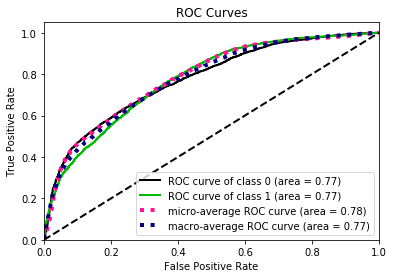

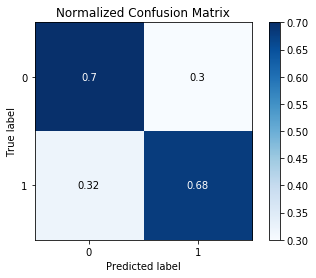

In [26]:
%%time
#clf1, X_train, X_test, y_train, y_test

model1= train_logistic_PCA_pipeline(X, pH, min_n=5, max_n= 10, pH_cut_off = 7.0, n_cs=10)

In [81]:
print(metrics.classification_report(model1[4],model1[0].predict(model1[2]) ))

              precision    recall  f1-score   support

           0       0.85      0.70      0.77      7770
           1       0.47      0.68      0.56      3030

    accuracy                           0.69     10800
   macro avg       0.66      0.69      0.66     10800
weighted avg       0.74      0.69      0.71     10800



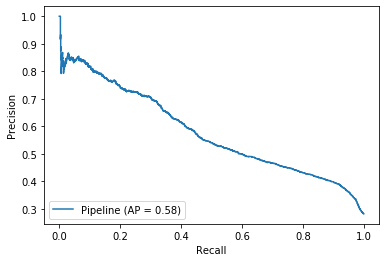

In [27]:
# precision = positive predictive value
# recall = True positive Rate or sensitivity
metrics.plot_precision_recall_curve(model1[0], model1[2], model1[4] )

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   12.2s
[Parallel(n_jobs=6)]: Done 300 out of 300 | elapsed:   18.8s finished
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:1537: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 2.
  warnings.warn("'n_jobs' > 1 does not have any effect when"


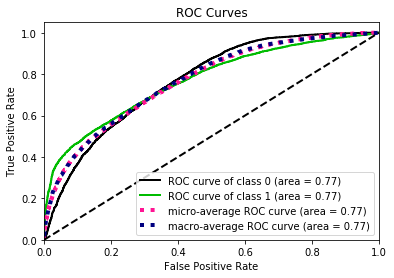

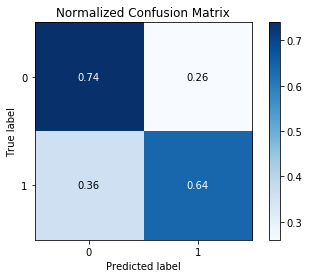

In [30]:
model2 = train_logistic_PCA_pipeline(X, pH, min_n=5, max_n= 10, pH_cut_off = 6.7, n_cs=20)

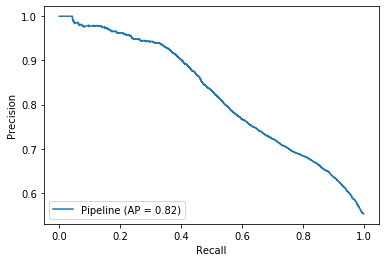

In [31]:
# precision = positive predictive value
# recall = True positive Rate or sensitivity
metrics.plot_precision_recall_curve(model2[0], model2[2], model2[4] )

In [80]:
print(metrics.classification_report(model2[4],model2[0].predict(model2[2]) ))

              precision    recall  f1-score   support

           0       0.94      0.72      0.82      9542
           1       0.24      0.68      0.36      1258

    accuracy                           0.72     10800
   macro avg       0.59      0.70      0.59     10800
weighted avg       0.86      0.72      0.76     10800



## Multi class

In [77]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

pHclass = pd.cut(pH,4)

le.fit(pHclass)

pHclass_coded = le.transform(pHclass)

C = pd.DataFrame(pd.Series(pHclass_coded).unique(),columns=['class_code'])
C['pH range'] = le.inverse_transform(C.class_code)
C

,class_code,pH range
0,0,"(6.219, 6.498]"
1,1,"(6.498, 6.775]"
2,2,"(6.775, 7.052]"
3,3,"(7.052, 7.33]"


Fitting 3 folds for each of 2250 candidates, totalling 6750 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    2.8s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   20.1s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   47.3s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.4min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  2.6min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  3.9min
[Parallel(n_jobs=6)]: Done 2438 tasks      | elapsed:  5.7min
[Parallel(n_jobs=6)]: Done 3188 tasks      | elapsed:  8.2min
[Parallel(n_jobs=6)]: Done 4038 tasks      | elapsed: 11.9min
[Parallel(n_jobs=6)]: Done 4988 tasks      | elapsed: 16.1min
[Parallel(n_jobs=6)]: Done 6038 tasks      | elapsed: 20.4min
[Parallel(n_jobs=6)]: Done 6750 out of 6750 | elapsed: 23.5min finished
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 

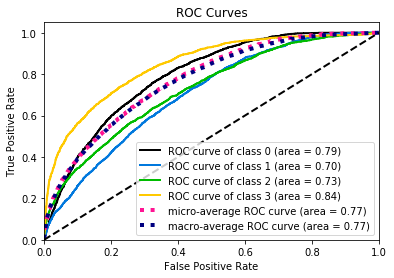

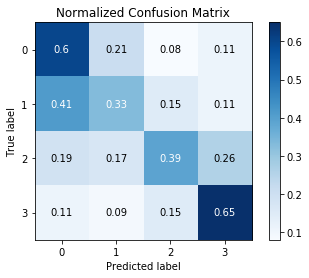

In [78]:
model3 = train_logistic_PCA_pipeline(X, pHclass_coded, min_n=5, max_n= 80, pH_cut_off = 6.7, n_cs=30,ignore_cut=True)

In [79]:
print(metrics.classification_report(model3[4],model3[0].predict(model3[2]) ))

              precision    recall  f1-score   support

           0       0.46      0.60      0.52      2753
           1       0.41      0.33      0.37      2736
           2       0.51      0.39      0.44      2730
           3       0.56      0.65      0.60      2581

    accuracy                           0.49     10800
   macro avg       0.49      0.49      0.48     10800
weighted avg       0.49      0.49      0.48     10800



## All measurable data for cut off at pH = 7.0

Fitting 3 folds for each of 800 candidates, totalling 2400 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:703: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    6.0s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:   23.8s
[Parallel(n_jobs=6)]: Done 438 tasks      | elapsed:   54.9s
[Parallel(n_jobs=6)]: Done 788 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done 1238 tasks      | elapsed:  2.7min
[Parallel(n_jobs=6)]: Done 1788 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done 2400 out of 2400 | elapsed:  5.5min finished
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/model_selection/_search.py:821: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0

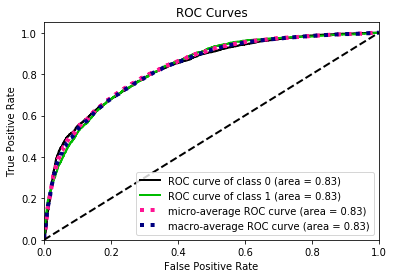

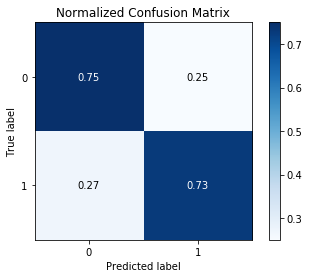

In [105]:
drop_cols = ['pH','FILE','ApproT1(sec)','Conc(mM)','Temp']

X = data.drop(drop_cols,axis = 1)
y = data.pH.copy()

clf4, X_train, X_test, y_train, y_test = train_logistic_PCA_pipeline(X, y, min_n=20,
                                                                     max_n= 60, pH_cut_off = 7.0, n_cs=10
                                                                     ,ignore_cut=False)

In [111]:
LR = clf4['logistic']

In [112]:
LR.coef_

array([[ 0.00269872,  0.07100019,  0.13473556,  0.16075995,  0.5760779 ,
         0.36788563,  0.04277198, -0.6266454 , -0.09443224,  2.69094975,
         0.08913821, -1.51548338, -0.03350394,  0.53025747,  0.69581369,
         0.0341138 ,  0.10298353, -0.22981488,  0.04750932, -0.64364436,
        -1.72086183, -0.45752479,  0.7723396 , -0.65648314, -2.16200802,
         1.68853017,  0.08609659,  0.54827722, -1.00803367, -1.53479695,
         1.0933664 ,  0.66989431, -0.84076061, -0.19592978, -1.04523421]])

In [106]:
clf4

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=35,
                     random_state=42, svd_solver='auto', tol=0.0,
                     whiten=False)),
                ('logistic',
                 LogisticRegression(C=2.1544346900318843,
                                    class_weight='balanced', dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=1000,
                                    multi_class='auto', n_jobs=2, penalty='l1',
                                    random_state=42, solver='liblinear',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [107]:
print(metrics.classification_report(y_test, clf4.predict(X_test)) )

              precision    recall  f1-score   support

           0       0.88      0.75      0.81      7770
           1       0.53      0.73      0.62      3030

    accuracy                           0.75     10800
   macro avg       0.71      0.74      0.71     10800
weighted avg       0.78      0.75      0.76     10800



In [108]:
for S in data['SatTime(ms)'].unique():
    f = X_test['SatTime(ms)'] == S
    score = metrics.recall_score(y_test[f], clf4.predict( X_test[f]) )
    print(S,score)
    
    

2000 0.7551867219917012
1000 0.7405857740585774
500 0.68
3000 0.7550644567219152
4000 0.7151394422310757
6000 0.7523809523809524


In [ ]:
Xdata = X.drop('100',axis  = 1).copy()

conc_filter = data['Conc(mM)'] > 20

clf_01,  _, _, _, _  = train_logistic_PCA_pipeline( Xdata[conc_filter], pH[conc_filter], min_n=2, max_n= 40, pH_cut_off = 7.0, n_cs= 20)

print(clf_01)

###  -training pH >7.0
## at 37 celsius

In [ ]:
f1 = data['Temp'] == 37

for C in metadata:
    print(C)
    print(data[f1][C].unique())
    print('---'*20)
    
    
X = data[f1].drop(metadata,axis = 1)
Z = X.apply(foo, axis = 1)
print(X.shape)
print(Z.shape)

pH = data[f1]['pH'].copy()


clf_02,  _, _, _, _  = train_logistic_PCA_pipeline( Z, pH, min_n=2, max_n= 40, pH_cut_off = 7.0, n_cs= 20)
print(clf_02)

In [ ]:
print( metrics.classification_report(pH > 7, clf_02.predict(Z)) )

##  training pH >7.0
### - at 37 celsius & T1  = 3.4

In [ ]:
f1 = data['Temp'] == 37
f2 = data['ApproT1(sec)'] == 3.4


for C in metadata:
    print(C)
    print(data[f1&f2][C].unique())
    print('---'*20)
    
    
X = data[f1&f2].drop(metadata,axis = 1)
Z = X.apply(foo, axis = 1)
print(X.shape)
print(Z.shape)

pH = data[f1&f2]['pH'].copy()


clf_04,  _, _, _, _  = train_logistic_PCA_pipeline( Z, pH, min_n=2, max_n= 40, pH_cut_off = 7.0, n_cs= 20)
print(clf_04)

In [ ]:
print( metrics.classification_report(pH > 7, clf_04.predict(Z)) )

print( metrics.confusion_matrix(pH > 7, clf_04.predict(Z)) )

print( metrics.cohen_kappa_score(pH > 7, clf_04.predict(Z)) )

In [ ]:
plt.plot(xdata, Z.mean(),'-k')
plt.plot(xdata, Z.mean() + Z.std(),'--r')

plt.xlim([-12,12])
plt.title('Average Nornalized Z-spectra')

##  training pH >7.0
### - at 42 celsius & T1  = 0.43

In [ ]:
f1 = data['Temp'] == 42
f2 = data['ApproT1(sec)'] == .43


for C in metadata:
    print(C)
    print(data[f1&f2][C].unique())
    print('---'*20)
    
    
X = data[f1&f2].drop(metadata,axis = 1)
Z = X.apply(foo, axis = 1)
print(X.shape)
print(Z.shape)

pH = data[f1&f2]['pH'].copy()


clf_05,  _, _, _, _  = train_logistic_PCA_pipeline( Z, pH, min_n=2, max_n= 40, pH_cut_off = 6.5, n_cs= 20)
print(clf_05)

In [ ]:
print( metrics.classification_report(pH > 7, clf_05.predict(Z)) )

print( metrics.confusion_matrix(pH > 7, clf_05.predict(Z)) )

print( metrics.cohen_kappa_score(pH > 7, clf_05.predict(Z)) )

In [ ]:
pd.Series(pH > 7).value_counts(normalize  = 1)

In [ ]:
z1 = data[ data.pH == 6.23 ].iloc[:,6::].mean()
z1 = z1 / z1[1]


z2 = data[ data.pH == 7.17 ].iloc[:,6::].mean()
z2 = z2 / z2[1]

z1.plot()
z2.plot()

In [ ]:
data.pH.unique()

In [ ]:
plt.plot(xdata, Z.mean(),'-k')
plt.plot(xdata, Z.mean() + Z.std(),'--r')

plt.xlim([-12,12])
plt.title('Average Nornalized Z-spectra')